In [90]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.datasets import UPFD
import networkx as nx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_max_pool as gmp, GATConv
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch import optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
train_data = UPFD(root="/home/arnabdey/Placement_ML_projects/.vscode/Graph NN/Datasets", name="gossipcop", feature="content", split="train")
test_data = UPFD(root="/home/arnabdey/Placement_ML_projects/.vscode/Graph NN/Datasets", name = "gossipcop", feature="content", split="test")
print("Train Samples: ", len(train_data))
print("Test Samples: ", len(test_data))

Extracting /home/arnabdey/Placement_ML_projects/.vscode/Graph NN/Datasets/gossipcop/raw/data.zip
Processing...
Done!


Train Samples:  1092
Test Samples:  3826


In [11]:
print(train_data[1].num_nodes)

125


Convert to networkX data format

In [13]:
def to_networkx(data, node_attrs=None, edge_attrs=None, to_undirected=False, remove_self_loops=False):
    if to_undirected:
        G = nx.Graph()
    else:
        G = nx.DiGraph()
    G.add_nodes_from(range(data.num_nodes))
    node_attrs, edge_attrs = node_attrs or [], edge_attrs or []
    values = {}
    for key, item in data(*(node_attrs + edge_attrs)):
        if torch.is_tensor(item):
            values[key] = item.squeeze().tolist()
        else:
            values[key] = item
        if isinstance(values[key], (list, tuple)) and len(values[key]) == 1:
            values[key] = item[0]
    for i, (u, v) in enumerate(data.edge_index.t().tolist()):
        if to_undirected and v > u:
            continue
        if remove_self_loops and u == v:
            continue
        G.add_edge(u, v)
        for key in edge_attrs:
            G[u][v][key] = values[key][i]
    for key in node_attrs:
        for i, feat_dict in G.nodes(data=True):
            feat_dict.update({key: values[key][i]})
    return G

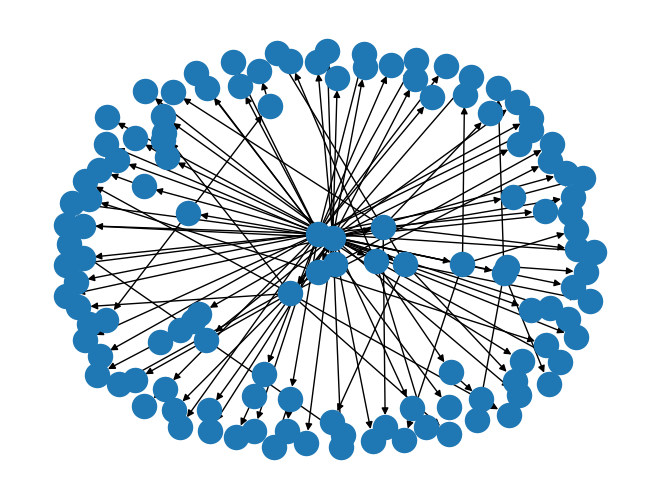

In [19]:
nx.draw(to_networkx(train_data[1]))

<Axes: >

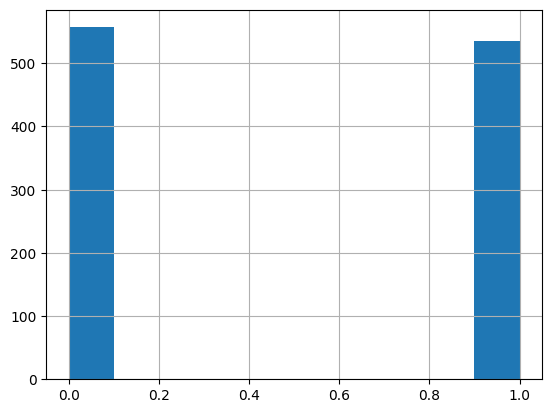

In [21]:
labels = [data.y.item() for i, data in enumerate(train_data)]
df = pd.DataFrame(labels, columns=["Labels"])
df["Labels"].hist()

In [22]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [39]:
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()

        self.conv1 = GATConv(in_channels=in_channels, out_channels=hidden_channels)
        self.conv2 = GATConv(in_channels=hidden_channels, out_channels=hidden_channels)
        self.conv3 = GATConv(in_channels=hidden_channels, out_channels=hidden_channels)

        self.lin_news = nn.Linear(in_channels, hidden_channels)
        self.lin0 = nn.Linear(hidden_channels, hidden_channels)
        self.lin1 = nn.Linear(2*hidden_channels, out_channels)

        self.act = nn.GELU()
        self.sig = nn.Sigmoid()
    
    def forward(self, x, edge_index, batch):

        h = self.act(self.conv1(x, edge_index))
        h = self.act(self.conv2(h, edge_index))
        h = self.act(self.conv3(h, edge_index))

        h = gmp(h, batch)

        h = self.act(self.lin0(h))

        root = (batch[1:] - batch[:-1]).nonzero(as_tuple=False).view(-1)
        root = torch.cat([root.new_zeros(1), root + 1], dim=0)

        news = x[root]
        news = self.act(self.lin_news(news))

        out = self.lin1(torch.cat([h, news], dim=-1))
        out = self.sig(out)

        return out
GNN(train_data.num_features, 128, 1)

GNN(
  (conv1): GATConv(310, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin_news): Linear(in_features=310, out_features=128, bias=True)
  (lin0): Linear(in_features=128, out_features=128, bias=True)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
  (act): GELU(approximate='none')
  (sig): Sigmoid()
)

In [40]:
model = GNN(in_channels=train_data.num_features, hidden_channels=128, out_channels=1)
model = torch.compile(model).to('cuda')

In [44]:
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
loss_fn = nn.BCELoss()
torch.set_float32_matmul_precision('high')

In [45]:
losses = []

for epoch in tqdm(range(50)):
    total_loss = 0.0

    for data in train_loader:
        data = data.to('cuda')
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(torch.reshape(out, (-1,)), data.y.float())
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * data.num_graphs
        total_loss /= len(train_loader.dataset)

        losses.append(total_loss)

  0%|          | 0/50 [00:00<?, ?it/s]/home/arnabdey/.local/lib/python3.8/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
100%|██████████| 50/50 [01:08<00:00,  1.36s/it]


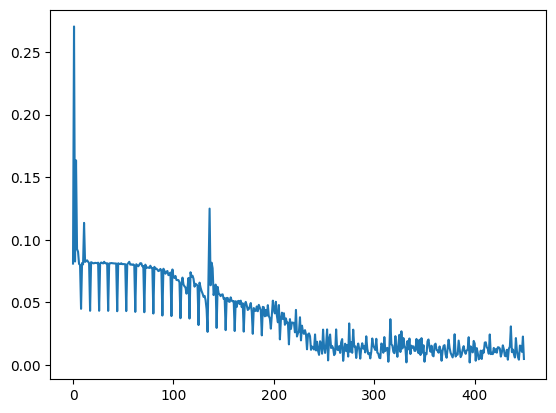

In [47]:
plt.plot(losses)
plt.show()

In [78]:
predictions = torch.tensor((1,), dtype = torch.float32)
actuals = torch.tensor((1,), dtype = torch.float32)
with torch.no_grad():
    for data in test_loader:
        data = data.to('cuda')
        pred = model(data.x, data.edge_index, data.batch)
        df = pd.DataFrame()

        prediction = torch.round(pred.cpu().detach().reshape(-1))
        actual = data.y.cpu().reshape(-1)

        predictions = torch.cat([predictions, prediction])
        actuals = torch.cat([actuals, actual])
        

In [86]:
c_matrix = confusion_matrix(y_true=actuals, y_pred=predictions)
accu = accuracy_score(y_true=actuals, y_pred=predictions)
f1 = f1_score(y_true=actuals, y_pred=predictions)

In [87]:
print(f"Accuracy = {accu}")
print(f"F1 Score = {f1}")

Accuracy = 0.9736085706819964
F1 Score = 0.9737457759292956


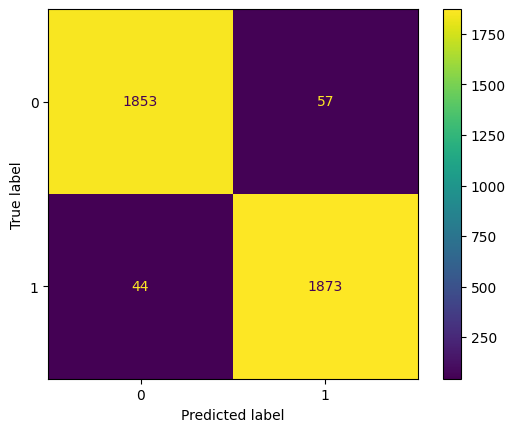

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
disp.plot()
plt.show()